In [13]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import tqdm
import os

In [14]:
# rcParams['font.family'] = 'NanumSquare'
rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

BERT 임베딩 중: 100%|██████████| 197/197 [00:02<00:00, 85.36it/s]


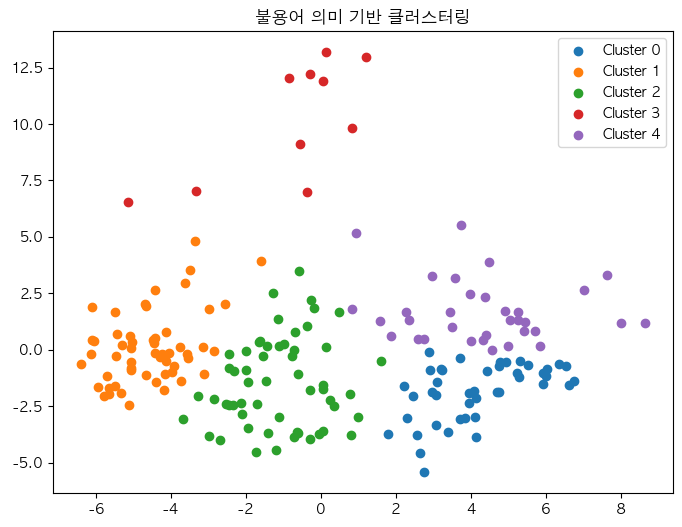


최종 통합 불용어 수: 197
예시: ['치도', '소프트볼', '로컬', '농구', '탐보브', '노르망디', '브루어', '데뷔전', '라이언스', '실증', '브라이언', '라이온스', '왁스', '피벗', '본받다', '송신', '딜런', '광전지', '리드', '토우']


,final_stopwords
0,치도
1,소프트볼
2,로컬
3,농구
4,탐보브
...,...
192,간염
193,투야
194,슬로
195,멜로디


In [15]:
# 데이터 로드
df = pd.read_csv("../01_데이터수집/data/finance_data.csv").drop_duplicates(subset=["kor_sentence"])
texts = df["kor_sentence"].tolist()

# 의미 있는 단어만 문장 단위로 추출
okt = Okt()
exclude_words = {'것', '등', '수', '이', '그', '저', '데', '자기', '때문', '자신', '대한'}  # 의존 명사 제거

def clean_and_tokenize(text):
    tokens = okt.pos(text, stem=True)
    return [
        word for word, pos in tokens
        if pos in ['Noun', 'Adjective', 'Verb']
        and len(word) > 1
        and word not in exclude_words
    ]

tokenized_docs = [clean_and_tokenize(text) for text in texts]
joined_docs = [" ".join(tokens) for tokens in tokenized_docs]

# TF-IDF 기반 불용어 후보
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(joined_docs)
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.mean(axis=0).A1
tfidf_dict = dict(zip(feature_names, tfidf_scores))
sorted_words = sorted(tfidf_dict.items(), key=lambda x: x[1])
low_tfidf_words = [w for w, score in sorted_words[:int(len(sorted_words) * 0.03)]]

# 보호 단어 생성
protected_keywords = {
    '증가', '감소', '매출', '계약', '이익', '시장',
    '하락', '상승', '수익', '손실', '주가', '투자',
    '영업', '가격', '판매', '실적', '성장', '재무',
    '호재', '악재', '확장', '지출', '기회', '위험'
}
final_stopwords = [w for w in low_tfidf_words if w not in protected_keywords]

# BERT 임베딩 기반 클러스터링
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
model = BertModel.from_pretrained("klue/bert-base").to(device)
model.eval()

def get_embedding(word):
    inputs = tokenizer(word, return_tensors="pt", truncation=True, max_length=10).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[0][0].cpu().numpy()

embedding_list = []
valid_stopwords = []

for word in tqdm(final_stopwords, desc="BERT 임베딩 중"):
    try:
        vec = get_embedding(word)
        embedding_list.append(vec)
        valid_stopwords.append(word)
    except Exception as e:
        print(f"'{word}' 임베딩 실패: {e}")

# 차원 축소 (PCA)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_list)

# 클러스터링 (KMeans)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(reduced_embeddings)

# 시각화
plt.figure(figsize=(8,6))
for i in range(n_clusters):
    points = reduced_embeddings[np.array(labels) == i]
    plt.scatter(points[:,0], points[:,1], label=f"Cluster {i}")
plt.title("불용어 의미 기반 클러스터링")
plt.legend()
plt.show()

# 가장 일반적인 의미의 클러스터만 불용어로 간주
most_common_label = Counter(labels).most_common(1)[0][0]
clustered_stopwords = [
    word for word, label in zip(valid_stopwords, labels)
    if label == most_common_label
]

# 병합 및 보호 단어 제외
merged_stopwords = set(final_stopwords) | set(clustered_stopwords)
final_filtered_stopwords = [w for w in merged_stopwords if w not in protected_keywords]

print(f"\n최종 통합 불용어 수: {len(final_filtered_stopwords)}")
print("예시:", final_filtered_stopwords[:20])

df_final_stopwords = pd.DataFrame(final_filtered_stopwords, columns=['final_stopwords'])
df_final_stopwords

In [73]:
# 1번 방법
# 전체 문장에서 너무 자주 등장하는 단어를 불용어로 간주 - 빈도 기반 상위 n%

okt = Okt()
all_words = []

# 토큰화
for text in texts:
    tokens = okt.pos(text, stem=True)
    all_words.extend([w for w, pos in tokens if pos in ['Noun', 'Adjective', 'Verb'] and len(w) > 1])

# 빈도 계산
counter = Counter(all_words)
total = sum(counter.values())

# 전체에서 가장 많이 나온 상위 n% 단어를 불용어 후보로 선택
top_k = int(len(counter) * 0.03)  # 상위 3%
candidate_stopwords = [w for w, _ in counter.most_common(top_k)]

print("불용어 후보:", candidate_stopwords)

불용어 후보: ['하다', '있다', '되다', '유로', '핀란드', '회사', '늘다', '이다', '증가', '매출', '되어다', '이익', '서비스', '밝히다', '영업', '그룹', '사업', '계약', '예정', '따르다', '시장', '대한', '제공', '기간', '새롭다', '발표', '업체', '주식', '생산', '포함', '감소', '인수', '개발', '공장', '제품', '투자', '헬싱키', '크다', '고객', '솔루션', '손실', '기록', '가다', '오이', '기술', '직원', '비다', '은행', '운영', '같다', '오다', '판매', '노키아', '순이익', '공급', '건설', '기업', '예상', '우리', '산업', '오늘', '시스템', '거래', '러시아', '이번', '않다', '위해', '제조업체', '현재', '계획', '지역', '사용', '시작', '프로젝트', '통해', '체결', '동안', '명의', '수익', '또한', '다른', '가격', '스웨덴', '가장', '두다', '관리', '받다', '이상', '달러', '부문', '목표', '모든', '백만', '매각', '미국', '주문', '모바일', '기계', '본사', '보유', '돼다', '제조', '최대', '네트워크', '이전', '해당', '하락', '관련', '소프트웨어', '이사회', '세계', '통신', '연간', '장비', '비용', '가치', '보고', '대비', '보다', '주요', '노르', '결과', '부동산', '전체', '전략', '자본', '정보', '비즈니스', '위치', '세다', '기반', '소유', '유지', '가지', '자회사', '동기', '미디어', '지원', '협상', '분야', '라인', '데이터', '주다', '설립', '브랜드', '발행', '국가', '결정', '성장', '제안', '뉴스', '시설', '협력', '시키다', '추가', '중국', '보고서', '현지', '유럽', '전자'

In [74]:
# 2번 방법
# 모든 label에 고르게 등장하는 단어 추출

# 각 label별 단어 집합 추출
label_words = {0: [], 1: [], 2: []}  # 중립, 긍정, 부정

for label in [0, 1, 2]:
    for text in df[df["labels"] == label]["kor_sentence"]:
        tokens = okt.pos(text, stem=True)
        label_words[label].extend([w for w, pos in tokens if pos in ['Noun', 'Adjective', 'Verb'] and len(w) > 1])

# 각 단어가 몇 개의 클래스에서 등장하는지 확인
all_labels = {word: 0 for word in set(label_words[0] + label_words[1] + label_words[2])}
for word in all_labels:
    all_labels[word] = sum([word in label_words[label] for label in [0,1,2]])

# 모든 label에서 등장한 단어
candidate_stopwords = [word for word, count in all_labels.items() if count == 3]
print("label 전반에 걸쳐 등장하는 불용어 후보:", candidate_stopwords)

label 전반에 걸쳐 등장하는 불용어 후보: []


In [75]:
# 3번 방법
# 문장당 자주 등장하는 단어 수집 후 TF기반 필터링

tf_counter = Counter()

for text in texts:
    tokens = okt.pos(text, stem=True)
    words = [w for w, pos in tokens if pos in ['Noun', 'Adjective', 'Verb'] and len(w) > 1]
    tf_counter.update(set(words))  # 문장 내 중복 제거하여 update

# 일정 문서 이상에 등장한 단어는 너무 흔한 단어로 간주
min_df = int(len(texts) * 0.3)  # 전체 문장의 30% 이상에 등장
candidate_stopwords = [w for w, c in tf_counter.items() if c > min_df]
print("문장 다수에 등장하는 단어 → 불용어 후보:", candidate_stopwords)

문장 다수에 등장하는 단어 → 불용어 후보: ['하다']


In [76]:
# 금융 불용어 추가 생성

financial_stopwords = {
    "시장", "주가", "증시", "투자", "매수", "매도", "주식", "증권", 
    "코스피", "코스닥", "기업", "경제", "금융", "지수", "수익", 
    "매출", "실적", "전망", "환율", "금리", "거래", "포트폴리오"
}

### 감성 사전 구축

In [77]:
# 데이터 로드
df = pd.read_csv("../01_데이터수집/data/finance_data.csv").drop_duplicates(subset=["kor_sentence"])
df["labels"] = df["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})
texts = df["kor_sentence"].tolist()

okt = Okt()

# 불용어 후보 생성 (상위 3% 빈도 단어 + 금융 특화)
all_words = []
for text in texts:
    tokens = okt.pos(text, stem=True)
    all_words.extend([w for w, pos in tokens if pos in ['Noun', 'Adjective', 'Verb'] and len(w) > 1])

counter = Counter(all_words)
top_k = int(len(counter) * 0.03)
high_freq_stopwords = set([w for w, _ in counter.most_common(top_k)])

# 금융 특화 불용어
financial_stopwords = {
    "시장", "주가", "증시", "투자", "매수", "매도", "주식", "증권", 
    "코스피", "코스닥", "기업", "경제", "금융", "지수", "수익", 
    "매출", "실적", "전망", "환율", "금리", "거래", "포트폴리오"
}

# 전체 불용어 세트
candidate_stopwords = high_freq_stopwords | financial_stopwords

# 토큰 추출 함수
def extract_tokens(text):
    tokens = okt.pos(text, stem=True)
    return [
        word for word, pos in tokens
        if pos in ["Noun", "Adjective", "Verb"] and len(word) > 1 and word not in candidate_stopwords
    ]   # 불용어는 제거 후 반환

# 긍정 / 부정 문장 분리
pos_sentences = df[df["labels"] == 1]["kor_sentence"]
neg_sentences = df[df["labels"] == 2]["kor_sentence"]

# 단어 수집
pos_words, neg_words = [], []
for s in pos_sentences:
    pos_words.extend(extract_tokens(s))
for s in neg_sentences:
    neg_words.extend(extract_tokens(s))

# 빈도 및 점수 계산
pos_counter = Counter(pos_words)
neg_counter = Counter(neg_words)
all_tokens = set(pos_counter) | set(neg_counter)

scores = {}
for word in all_tokens:
    pf, nf = pos_counter.get(word, 0), neg_counter.get(word, 0)
    scores[word] = round((pf - nf) / (pf + nf + 1e-5), 4)

os.makedirs("sentiment_dictionary", exist_ok=True)

# 긍정 단어 DataFrame 생성 및 저장
positive_with_score = [(word, count, scores[word]) for word, count in pos_counter.items()]
df_positive = pd.DataFrame(positive_with_score, columns=["단어", "빈도", "점수"])
df_positive = df_positive.sort_values(by="빈도", ascending=False).reset_index(drop=True)
# df_positive.to_csv("sentiment_dictionary/positive_words_dict.csv", index=False, encoding="utf-8-sig")

# 부정 단어 DataFrame 생성 및 저장
negative_with_score = [(word, count, scores[word]) for word, count in neg_counter.items()]
df_negative = pd.DataFrame(negative_with_score, columns=["단어", "빈도", "점수"])
df_negative = df_negative.sort_values(by="빈도", ascending=False).reset_index(drop=True)
# df_negative.to_csv("sentiment_dictionary/negative_words_dict.csv", index=False, encoding="utf-8-sig")

print("긍정 단어 수:", len(df_positive))
print("부정 단어 수:", len(df_negative))

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_8591/3790149314.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["labels"] = df["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})


긍정 단어 수: 2895
부정 단어 수: 1371


In [78]:
df_positive

,단어,빈도,점수
0,절감,32,0.8824
1,효율,32,0.9394
2,수주,29,0.8710
3,판매량,24,0.5484
4,늘리다,23,1.0000
...,...,...,...
2890,리기,1,1.0000
2891,확고하다,1,1.0000
2892,범주,1,1.0000
2893,어업,1,1.0000


In [79]:
df_negative

,단어,빈도,점수
0,상반기,27,-0.5882
1,일시,23,-1.0000
2,비교,21,-0.2727
3,감축,19,-1.0000
4,인하다,17,-0.4167
...,...,...,...
1366,동석,1,0.0000
1367,리키,1,-1.0000
1368,케르만,1,-1.0000
1369,사비,1,-1.0000


In [ ]:
# CSV 로드
df_positive = pd.read_csv("sentiment_dictionary/positive_words_dict.csv")
df_negative = pd.read_csv("sentiment_dictionary/negative_words_dict.csv")

# TF-IDF 벡터화
all_words = list(set(df_positive["단어"]).union(set(df_negative["단어"])))
vectorizer = TfidfVectorizer(vocabulary=all_words, analyzer='char', ngram_range=(2, 3))  # char n-gram 기반
vectors = vectorizer.fit_transform(all_words).toarray()

# 단어별 유사도 행렬
similarity_matrix = cosine_similarity(vectors)

# 각 단어에 대해 유사한 단어들의 가중 점수 평균 계산
def similarity_score(df, all_words, similarity_matrix):
    word2idx = {w: i for i, w in enumerate(all_words)}
    weighted_scores = []
    for _, row in df.iterrows():
        word, freq, score = row["단어"], row["빈도"], row["점수"]
        if word not in word2idx:
            weighted_scores.append(0)
            continue
        idx = word2idx[word]
        sims = similarity_matrix[idx]
        top_similar_idx = sims.argsort()[::-1][1:6]  # 가장 유사한 상위 5개 (자기 제외)
        weights = sims[top_similar_idx]
        related_scores = []
        related_weights = []

        for i, sim in zip(top_similar_idx, weights):
            related_word = all_words[i]
            match = df[df["단어"] == related_word]
            if not match.empty:
                related_scores.append(match["점수"].values[0])
                related_weights.append(sim)

        if related_scores:
            weight_sum = np.sum(related_weights)
            if weight_sum > 1e-5:
                sim_score = np.average(related_scores, weights=related_weights)
            else:
                sim_score = np.mean(related_scores)  # 유사도가 거의 0인 경우 단순 평균
        else:
            sim_score = 0
                
        weighted_scores.append(sim_score)
    return weighted_scores

# 빈도 정규화 함수 (0~1 스케일링)
def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-5)

# 각 사전에 대해 점수 계산
for df in [df_positive, df_negative]:
    df["빈도정규화"] = normalize(df["빈도"])
    df["유사도점수"] = similarity_score(df, all_words, similarity_matrix)
    df["최종점수"] = (
        df["점수"] * 0.6 +
        df["빈도정규화"] * 0.2 +
        df["유사도점수"] * 0.2
    ).round(4)

# 결과 저장
# df_positive.to_csv("sentiment_dictionary/final_positive_dict.csv", index=False)
# df_negative.to_csv("sentiment_dictionary/final_negative_dict.csv", index=False)

In [81]:
# 최종 점수 컬럼 내림차순 정렬
df_positive.sort_values(by='최종점수', ascending=False).head(10)

,단어,빈도,점수,빈도정규화,유사도점수,최종점수
1,효율,32,0.9394,1.000000,0.76,0.9156
2,수주,29,0.8710,0.903226,1.00,0.9032
23,발전,17,1.0000,0.516129,1.00,0.9032
31,설치,16,1.0000,0.483871,1.00,0.8968
43,향상,15,1.0000,0.451613,1.00,0.8903
40,협약,15,1.0000,0.451613,1.00,0.8903
50,처리,14,1.0000,0.419355,1.00,0.8839
49,리투아니아,14,1.0000,0.419355,1.00,0.8839
4,늘리다,23,1.0000,0.709677,0.70,0.8819
0,절감,32,0.8824,1.000000,0.76,0.8814


In [82]:
# 최종 점수 컬럼 내림차순 정렬
df_negative.sort_values(by='최종점수', ascending=False).head(10)

,단어,빈도,점수,빈도정규화,유사도점수,최종점수
1293,강화,1,0.8462,0.000000,0.846200,0.6770
920,활용,1,0.7778,0.000000,0.714300,0.6095
733,재활용,1,0.7143,0.000000,0.777800,0.5841
1289,구조,1,0.8571,0.000000,0.333300,0.5809
1176,범위,1,0.7143,0.000000,0.714300,0.5714
1182,바이킹,1,0.7778,0.000000,0.443503,0.5554
335,코퍼레이션,2,0.6667,0.038462,0.666700,0.5411
745,효율,1,0.9394,0.000000,-0.200000,0.5236
391,연결,2,0.6364,0.038462,0.636400,0.5168
1117,긍정,1,0.9091,0.000000,-0.200000,0.5055
